# Training a deep neural network on a real dataset

In this notebook, we will continue to explore how to train a (deep) neural network on a real dataset. For this purpose, we will use a subset of real dataset named Sat-6. This dataset originally contains 405k NAIP image patches of size 28 pix. $\times$ 28 pix. describing 6 land cover classes: buildings (0), barren land (1), trees (2), grassland (3), roads (4), and water bodies (5).
For computational reason, we will work with 15k image patches.

https://www.kaggle.com/crawford/deepsat-sat6


Let us start by importing some packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

As the data are stored in your drive account, we will first mount your Google drive on your runtime by using an authorization code. There exist other approaches to work with external data on Colab: https://colab.research.google.com/notebooks/io.ipynb

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Reading the data
We can now read the data and analyse them:

Data used in this example was obtained using the DeepSat Airborne Datasets available [here](https://www.kaggle.com/crawford/deepsat-sat6?select=y_train_sat6.csv). 

In [3]:
your_data_path = "~/Downloads/"
X = pd.read_csv(your_data_path + "data/sat6_x.csv", delimiter=',', header=None)
Y = pd.read_csv(your_data_path + "data/sat6_y.csv", delimiter=',', header=None)
print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)

patch_size = 28
classes = ["buildings", "barren land", "trees", "grassland", "roads", "water bodies"]
K = len(classes) # number of classes

X.shape:  (15000, 784)
Y.shape:  (15000, 1)


In [4]:
def visualize(x, y, p=28):
  plt.figure()
  plt.imshow(x.reshape((p,p)), cmap='gray')
  plt.title(classes[y])

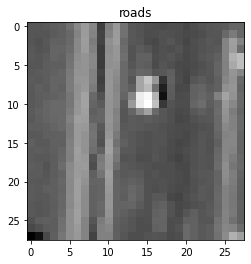

In [5]:
# Visualizing the data
ii = 18
visualize(X.iloc[ii].to_numpy(), Y.iloc[ii].item()) # grayscale image

As patches of this dataset are small (28 pixels $\times$ 28 pixels) and we extract only grayscale image, this is not easy to recognize the different classes. Change the value of `ii` to display patches belonging to other classes.

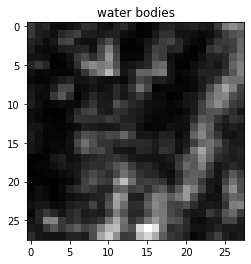

In [6]:
# Visualizing the data
ii = 15
visualize(X.iloc[ii].to_numpy(), Y.iloc[ii].item()) # grayscale image

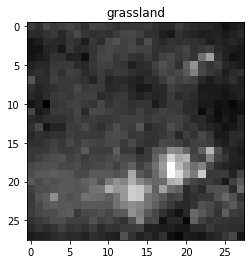

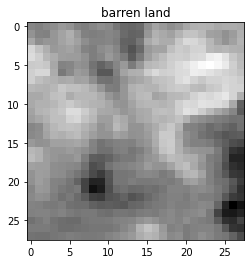

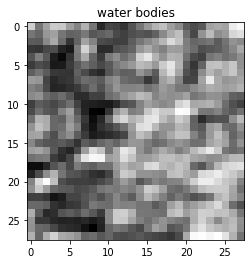

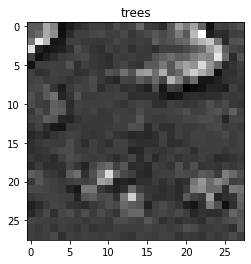

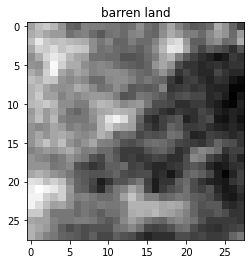

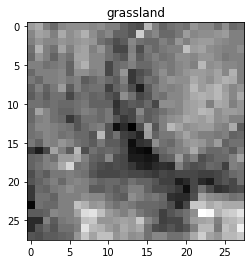

In [7]:
# Visualizing the data
idx = [1, 5, 8, 10, 20, 50]
for i in idx:
    visualize(X.iloc[i].to_numpy(), Y.iloc[i].item()) # grayscale image

In [8]:
# Create train and test splits 
X_train, X_test, Y_train, Y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.25, random_state=73) 

## A simple MLP

We will first start by reimplementing a MultiLayer Perceptron (MLP) as you have seen in the previous practical session. This architecture will be your baseline for the remaining of the practice.

Let us first define our class named Sat6MLP and declare an optimiser and the loss function

In [9]:
class Sat6MLP(nn.Module):
    def __init__(self, in_size, hidden_units, out_size):
        super(Sat6MLP, self).__init__()
        
        # Let us now define the linear layers we need:
        self.fc1 = nn.Linear(in_size, hidden_units) 
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, out_size)
        
    # We have also to define what is the forward of this module:
    def forward(self, x):
        h1 = nn.functional.relu(self.fc1(x))
        h2 = nn.functional.relu(self.fc2(h1))
        logits = self.fc3(h2)
        return logits

In [10]:
# Loss function
def loss_func(y_hat, y):
    return nn.CrossEntropyLoss()(y_hat, y)

In [11]:
# create Tensors from the train and test split of the input data
Y_train_t = torch.from_numpy(Y_train.flatten())
X_train_t = torch.FloatTensor(X_train)
Y_test_t = torch.from_numpy(Y_test.flatten())
X_test_t = torch.FloatTensor(X_test)

In [12]:
## This cell will take approximatively 4 minutes to run 
train_loss = [] # where we keep track of the loss
train_accuracy = [] # where we keep track of the accuracy of the model
iters = 1000 # number of training iterations

model = Sat6MLP(patch_size*patch_size,256,K) # the MLP model, K = number of classes

optimizer = optim.SGD(model.parameters(), lr=.01) # Gradient Descent optimiser

for i in range(iters):
    logits = model(X_train_t) # forward pass

    loss = loss_func(logits, Y_train_t) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    
    y_hat_class = np.argmax(logits.detach(), axis=1) # we assign an appropriate label based on the network's prediction
    accuracy = torch.sum(Y_train_t==y_hat_class) / len(Y_train) # compute final accuracy
    
    train_accuracy.append(accuracy)
    train_loss.append(loss.item())

Text(0, 0.5, 'Accuracy')

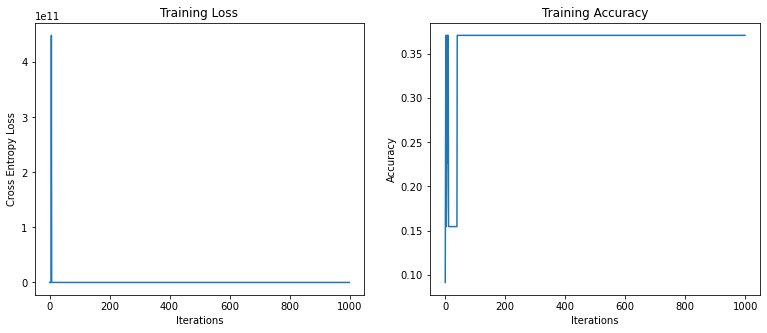

In [13]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(train_loss)
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')

plt.subplot(1, 2, 2)
plt.title('Training Accuracy')
plt.plot(train_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

The training loss is really high at the first iteration, and then there is a plateau in our training accuracy. We forgot an important processing step. Reread the whole code, and find what main data preparation step is missing.

Your explanation comes below:

The main data preparation step that was missing in the configuration of this model is the normalisation of the training data. Since we have a grayscale image, it is necessary to normalize each value around the total number of gray level values in the image we are working with. Without it, the first layer of the model would be forced to perform this data preparation and take this as the input into the next layer. This leads to, as seen in the visualization of the model performance above, very poor model with accuracy less then 50%. As best practice, it is suggested to always normalise the data, so as not to waste the first layer of the network in normalizing the data. 

## The same simple MLP with whole data preparation steps

As you might have found, we forgot to mean-centre the training data. Our previous network spend thus the first iteration to "normalise" the data, and fall into a local minimum.

In [14]:
#X_train = (X_train-np.mean(X_train))/np.std(X_train,ddof=1) # another type of data normalization
X_train = X_train/255 # normalize the data based on the number of gray values.
X_train_t = torch.FloatTensor(X_train)

In [15]:
## This cell will take about 3 to 4 minutes to run
train_loss = [] # where we keep track of the loss
train_accuracy = [] # where we keep track of the accuracy of the model
iters = 1000 # number of training iterations

model = Sat6MLP(patch_size*patch_size,256,K) # the MLP model
optimizer = optim.SGD(model.parameters(), lr=.01) # Gradient Descent optimiser

for i in range(iters):
    logits = model(X_train_t) # forward pass

    loss = loss_func(logits, Y_train_t) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    
    y_hat_class = np.argmax(logits.detach(), axis=1) # we assign an appropriate label based on the network's prediction
    accuracy = torch.sum(Y_train_t==y_hat_class) / len(Y_train) # compute final accuracy
    
    train_accuracy.append(accuracy)
    train_loss.append(loss.item())

Text(0, 0.5, 'Accuracy')

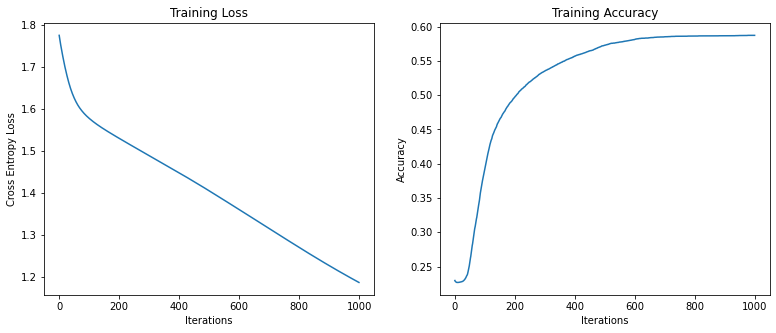

In [16]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(train_loss)
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')

plt.subplot(1, 2, 2)
plt.title('Training Accuracy')
plt.plot(train_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

We see a much better accuracy. After the data normalization, we can see an increase in model performance estimated by both the descent in the training loss and the increase in model accuracy shown in the performance graph above. 

## Speeding-up the network training

The training of these networks is long as we are updating the network parameters only once all the training data has been seen by the network. Even after the data normalisation, the training loss decreases very slowly, and the number of iterations seems to be too low as the network has not converged.
Before increasing the number of iterations (and maybe changing the architecture), let us speeding-up the training. First, we will use GPU power. Second, we will use the PyTorch data loader, which allows us to easily implement the mini-batch gradient descent algorithm.

### GPU

Let us start by training our MLP with the help of GPU. On colab, you will first need to `Change Runtime Type` in the `Runtime` menu. Select GPU for `Hardware Accelerator`. Once this is done the command line `torch.cuda.is_available()` should return `True`. It means the system has the Nvidia driver correctly installed.

In [17]:
torch.cuda.is_available()

True

Then, we need to transfer the tensor generated on CPU to GPU. To do this, PyTorch provides a simple API. Moreove, the new tensors are generated on the same device as the parent tensor (so you do not need to put all the tensors on GPU).

Usually, we first define a `device` variable:

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Then we transfer the training data to GPU by using the simple command `.to(device)`. We can check if a tensor is on GPU by using the `is_cuda` attribute.

In [19]:
print("Before: ", X_train_t.is_cuda)
X_train_t = X_train_t.to(device)
print("After: ", X_train_t.is_cuda)

Before:  False
After:  True


In [20]:
print("Before: ", Y_train_t.is_cuda)
Y_train_t = Y_train_t.to(device)
print("After: ", Y_train_t.is_cuda)


Before:  False
After:  True


We also do this operation for test data (that we will use later):

In [21]:
X_test_t = X_test_t.to(device)
Y_test_t = Y_test_t.to(device)

You can also get  more information about your system, e.g. number of GPUs and the type of GPU:

In [22]:
torch.cuda.device_count() # returns 1 in Colab
torch.cuda.get_device_name(0) # Lovely NVIDIA GeoForce RTX

'NVIDIA GeForce RTX 2060'

We will also need to redefine the model to ensure that the network parameters are saved in the correct device. Find all the code modifications that have been introduced below:

In [23]:
class MySat6MLP(nn.Module):
    def __init__(self, in_size, hidden_units, out_size, device=torch.device("cpu")):
        super(MySat6MLP, self).__init__()
        
        # Let us now define the linear layers we need:
        self.fc1 = nn.Linear(in_size, hidden_units, device=device)
        self.fc2 = nn.Linear(hidden_units, hidden_units, device=device)
        self.fc3 = nn.Linear(hidden_units, out_size, device=device)
        
    # We have also to define what is the forward of this module:
    def forward(self, x):
        h1 = nn.functional.relu(self.fc1(x))
        h2 = nn.functional.relu(self.fc2(h1))
        logits = self.fc3(h2)
        return logits


What are the two main modifications? Will this code work as well to be run on a GPU?



Your answer goes below

The first modification made was the specification of the device the MLP should use. The CPU device is specified as the default hardware accelerator, if there is no existing GPU on the hardware the model is ran on. The different layers in the network are also assigned to the CPU device. But this can also work on the GPU when overridden by the device parameter, which would automatically transfer the network to the hardware accelerator (for example  `torch.device("cuda")`). The central idea of running the Neural Net on the GPU is to fulfil these two prerequisites:  
- sending the data to the GPU device (in this case cuda)
- loading the network on the GPU device also.

**Note** We also need to modify the network training to use the CPU when computing the accuracy (as we use numpy methods).  
Please note the lines in the code below where `.cpu()` is used. When torch method is used, then the whole computation can be performed on the GPU, with all the data in the tensor datatype.

In [24]:
device

device(type='cuda', index=0)

In [25]:
train_loss = [] # where we keep track of the loss
train_accuracy = [] # where we keep track of the accuracy of the model
iters = 1000 # number of training iterations

model = MySat6MLP(patch_size*patch_size, 256, K, device) ## device = 'cuda' 

# overrides the internal specification
optimizer = optim.SGD(model.parameters(), lr=.01)

for i in range(iters):    
    logits = model(X_train_t) # forward pass

    loss = loss_func(logits, Y_train_t) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss

    optimizer.step() # perform one step of gradient descent

    optimizer.zero_grad() # reset the gradients to 0

    y_hat_class = torch.argmax(logits.detach(), axis = 1)
    
    accuracy = torch.sum(Y_train_t==y_hat_class) / len(Y_train_t) # compute final accuracy (all in torch)
    #accuracy = torch.sum(Y_train_t.cpu()==y_hat_class) / len(Y_train_t) # compute final accuracy (in numpy, remember to detach)
    
    train_accuracy.append(accuracy)
    train_loss.append(loss.item())

Text(0, 0.5, 'Accuracy')

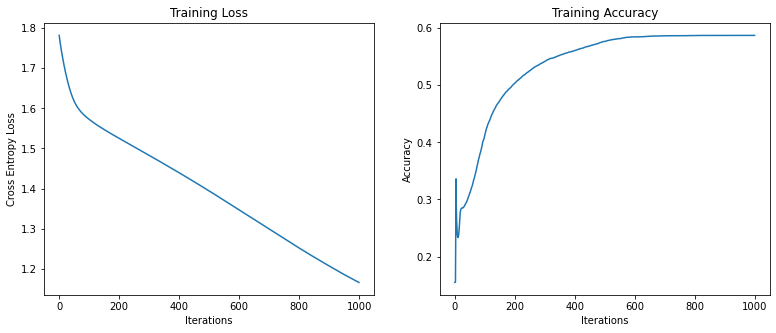

In [26]:
train_accuracy = [t.cpu().detach() for t in train_accuracy]

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(train_loss)
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')

plt.subplot(1, 2, 2)
plt.title('Training Accuracy')
plt.plot(train_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

This change does not affect the performance (we still have a training accuracy around 60 %), but it speeds-up the network training: from 4 minutes to a dozen of second!

### Data Loader
The second necessary step is the use of `DataLoader` to implement mini-batch gradient descent, and update more often the parameters.

In [27]:
from torch.utils.data import DataLoader, TensorDataset # import DataLoader and TensorDataset
batch_size = 32 # define the batch size

# Create dataset from several tensors with matching first dimension
# Samples will be drawn from the first dimension (rows)
# This is necessary to use the DataLoader
train_dataset = TensorDataset(X_train_t, Y_train_t)
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


We then need to rewrite the training loop to include iterations through batches.

In [28]:
class MySat6MLP(nn.Module):
    def __init__(self, in_size, hidden_units, out_size, device=torch.device("cpu")):
        super(MySat6MLP, self).__init__()
        
        # Let us now define the linear layers we need:
        self.fc1 = nn.Linear(in_size, hidden_units, device=device)
        self.fc2 = nn.Linear(hidden_units, hidden_units, device=device)
        self.fc3 = nn.Linear(hidden_units, out_size, device=device)
        
    # We have also to define what is the forward of this module:
    def forward(self, x):
        h1 = nn.functional.relu(self.fc1(x))
        h2 = nn.functional.relu(self.fc2(h1))
        logits = self.fc3(h2)
        return logits


In [29]:
train_loss = [] # where we keep track of the loss
train_accuracy = [] # where we keep track of the accuracy of the model
epochs = 40 # number of epochs

model = MySat6MLP(patch_size*patch_size, 256, K, device)
optimizer = optim.SGD(model.parameters(), lr=.01)

for e in range(epochs):
  train_correct = 0
  for x_train_batch, y_train_batch in train_dataset_loader:
    y_hat = model(x_train_batch) # forward pass

    loss = loss_func(y_hat, y_train_batch) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    y_hat_class = torch.argmax(y_hat, axis=1) # we assign an appropriate label based on the network's prediction == GPU
    #y_hat_class = torch.argmax(y_hat.cpu().detach(), axis=1) # when computing on CPU # we assign an appropriate label based on the network's prediction
    train_correct += torch.sum(y_hat_class==y_train_batch)
    train_loss.append(loss.item())
  train_accuracy.append(train_correct/len(train_dataset_loader.dataset))  

Text(0, 0.5, 'Accuracy')

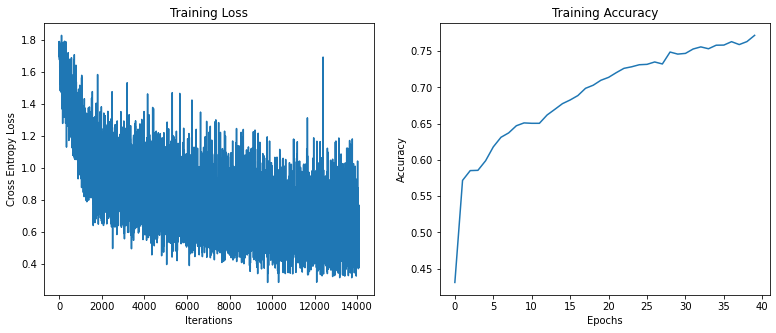

In [30]:
train_accuracy = [t.cpu().detach() for t in train_accuracy]

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(train_loss)
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')

plt.subplot(1, 2, 2)
plt.title('Training Accuracy')
plt.plot(train_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Usually, we also monitor the performance on a validation set. This allows for example to avoid overfitting by stopping the network training when the validation loss increases during several consecutive epochs. Let us implement this here. The test dataset is kept to perform an independent evaluation of the network. As the computation on extra samples might be costly, we compute validation loss and accuracy only every epochs (not every iterations).

In [31]:
batch_size

32

In [32]:
X_train_t, X_val_t, Y_train_t, Y_val_t = train_test_split(X_train_t, Y_train_t, test_size=0.2, random_state=37)

train_dataset = TensorDataset(X_train_t, Y_train_t)
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [33]:
train_loss = [] # where we keep track of the training loss
train_accuracy = [] # where we keep track of the training accuracy of the model
val_loss = [] # where we keep track of the validation loss
val_accuracy = [] # where we keep track of the validation accuracy of the model
epochs = 40 # number of epochs

model = MySat6MLP(patch_size*patch_size, 256, K, device)
optimizer = optim.SGD(model.parameters(), lr=.01)

for e in range(epochs):
  train_correct = 0
  for x_train_batch, y_train_batch in train_dataset_loader:
    y_hat = model(x_train_batch) # forward pass

    loss = loss_func(y_hat, y_train_batch) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    y_hat_class = torch.argmax(y_hat, axis=1) # we assign an appropriate label based on the network's prediction
    train_correct += torch.sum(y_hat_class==y_train_batch)
    train_loss.append(loss.item())
  
  train_accuracy.append(train_correct/len(train_dataset_loader.dataset)) 
  y_val_hat = model(X_val_t) # forward pass
  val_loss.append(loss_func(y_val_hat, Y_val_t).item()) # compute the loss
  y_val_hat_class = np.argmax(y_val_hat.cpu().detach(), axis=1) # we assign an appropriate label based on the network's prediction
  val_acc = torch.sum(y_val_hat_class==Y_val_t.cpu())/len(Y_val_t)
  val_accuracy.append(val_acc)

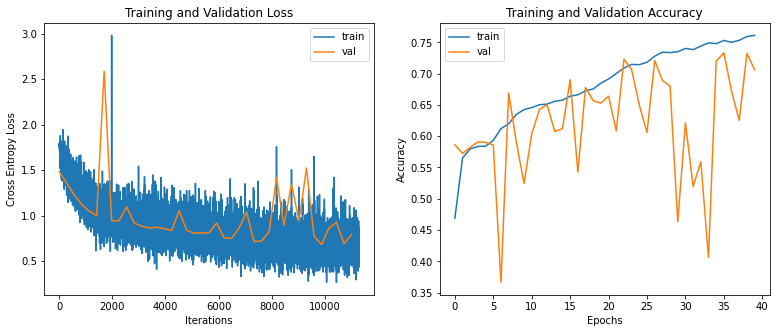

In [34]:
train_accuracy = [t.cpu().detach() for t in train_accuracy]
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss')
plt.plot(list(range(epochs*len(train_dataset_loader))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(train_dataset_loader),len(train_dataset_loader))), val_loss, label="val")
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy')
plt.plot(list(range(epochs)), train_accuracy, label="train")
plt.plot(list(range(epochs)),val_accuracy, label="val")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Your practice

In this section, you will train different networks. The main goal is to compare the performance (accuracy, convergence, etc.) to the "baseline" we train in the previous section. After the practice, you should understand how the different components of your network can influence its performance.

## Exercise 1: Impact of the architecture of the model


In this exercice, we will try different architecture. The goal is to find the architecture that give the most accurate predictions. We can also analyse the performance in terms of speed.
* Try to change the number of layers to the network (1, 2, 3, 5, 10, more ?).
* Try to change the number of units in hidden layers (1, 5, 25, 50, 100, 200, 500, more).
* Try different activaton functions, e.g., [sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.functional.sigmoid.html), [tanh](https://pytorch.org/docs/stable/generated/torch.nn.functional.tanh.html), [leaky ReLu](https://pytorch.org/docs/stable/generated/torch.nn.functional.leaky_relu.html#torch.nn.functional.leaky_relu), etc.

#### Change the number of layers in the network: (1, 2, 3, 5, 10, 20, ...)


In [35]:
device

device(type='cuda', index=0)

In [36]:
# Define a 5 layer network
class LayeredMLP(nn.Module):
  def __init__(self, in_size, hidden_units, out_size, device=torch.device("cpu")):
    super(LayeredMLP, self).__init__()
    # define a network of 5 linear layers.
    self.nnet = nn.Sequential(
        nn.Linear(in_size, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, out_size, device=device)
     )
    
  # define the forward pass of the model
  def forward(self, x):
    logits = self.nnet(x)
    return logits


# Define a 10 layer network
class Layer10MLP(nn.Module):
  def __init__(self, in_size, hidden_units, out_size, device=torch.device("cpu")):
    super(Layer10MLP, self).__init__()
    # define a network of 5 linear layers.
    self.nnet = nn.Sequential(
        nn.Linear(in_size, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, out_size, device=device),
     )
  # define the forward pass of the model
  def forward(self, x):
    logits = self.nnet(x)
    return logits


# Define a 20 layer network
class Layer20MLP(nn.Module):
  def __init__(self, in_size, hidden_units, out_size, device=torch.device("cpu")):
    super(Layer20MLP, self).__init__()
    # define a network of 5 linear layers.
    self.nnet = nn.Sequential(
        nn.Linear(in_size, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.ReLU(),
        nn.Linear(hidden_units, out_size, device=device),
     )
  # define the forward pass of the model
  def forward(self, x):
    logits = self.nnet(x)
    return logits

##### Define functions to train model and display the performance on the training and validation sets

In [37]:
# define functions for training model and display model performance
def train_nnet(model, optimizer, epochs, dataloader=train_dataset_loader):
    # training the nnet
    train_loss = [] # where we keep track of the training loss
    train_accuracy = [] # where we keep track of the training accuracy of the model
    val_loss = [] # where we keep track of the validation loss
    val_accuracy = [] # where we keep track of the validation accuracy of the model
    
    for e in range(epochs):
        train_correct = 0
        for x_train_batch, y_train_batch in train_dataset_loader:
            y_hat = model(x_train_batch) # forward pass
            
            loss = loss_func(y_hat, y_train_batch) # compute the loss
            loss.backward() # obtain the gradients with respect to the loss
            optimizer.step() # perform one step of gradient descent
            optimizer.zero_grad() # reset the gradients to 0
            y_hat_class = torch.argmax(y_hat.detach(), axis=1) # we assign an appropriate label based on the network's prediction
            train_correct += torch.sum(y_hat_class==y_train_batch)
            train_loss.append(loss.item())
            
        train_accuracy.append(train_correct/len(train_dataset_loader.dataset)) 
        y_val_hat = model(X_val_t) # forward pass
        val_loss.append(loss_func(y_val_hat, Y_val_t).item()) # compute the loss
        y_val_hat_class = torch.argmax(y_val_hat, axis=1) # we assign an appropriate label based on the network's prediction
        val_acc = torch.sum(y_val_hat_class==Y_val_t)/len(Y_val_t)
        val_accuracy.append(val_acc)

    return train_loss, train_accuracy, val_loss, val_accuracy


In [38]:
def plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs): 
    # plot
    train_accuracy = [t.cpu().detach() for t in train_accuracy]
    val_accuracy = [v.cpu().detach() for v in val_accuracy]
    #display model performanc
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Loss')
    plt.plot(list(range(epochs*len(train_dataset_loader))),train_loss, label="train")
    plt.plot(list(range(0, epochs*len(train_dataset_loader),len(train_dataset_loader))), val_loss, label="val")
    plt.xlabel('Iterations')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Accuracy')
    plt.plot(list(range(epochs)), train_accuracy, label="train")
    plt.plot(list(range(epochs)),val_accuracy, label="val")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

##### Display the performances of both models -- 5 Layers, 10 Layers

In [39]:
# 5 layer models
model5 = LayeredMLP(patch_size*patch_size, 256, K, device=device)
optimizer5 = optim.SGD(model5.parameters(), lr=.01)
print(model5)

LayeredMLP(
  (nnet): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=6, bias=True)
  )
)


In [40]:
# 10 layer models
model10 = Layer10MLP(patch_size*patch_size, 256, K, device=device)
optimizer10 = optim.SGD(model10.parameters(), lr=.01)
print(model10)

Layer10MLP(
  (nnet): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Linear(in_features=256, out_features=256, bias=True)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features=256, out_features=6, bias=True)
  )
)


In [41]:
# 20 layer models
model20 = Layer20MLP(patch_size*patch_size, 256, K, device=device)
optimizer20 = optim.SGD(model20.parameters(), lr=.01)
print(model20)

Layer20MLP(
  (nnet): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Linear(in_features=256, out_features=256, bias=True)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features=256, out_features=256, bias=True)
    (19): ReLU()
    (20): Linear(in_features=256, out_features=256, bias=True)
    (21): ReLU()
    (22): Linear(in_features=256, out_features=256, bias=True)
    (23): ReLU()
    (24): Linear

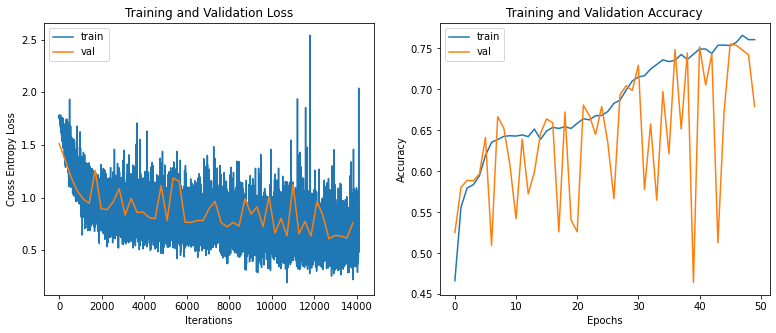

In [42]:
train_loss, train_accuracy, val_loss, val_accuracy = train_nnet(model5, optimizer5, epochs = 50)
plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 50)

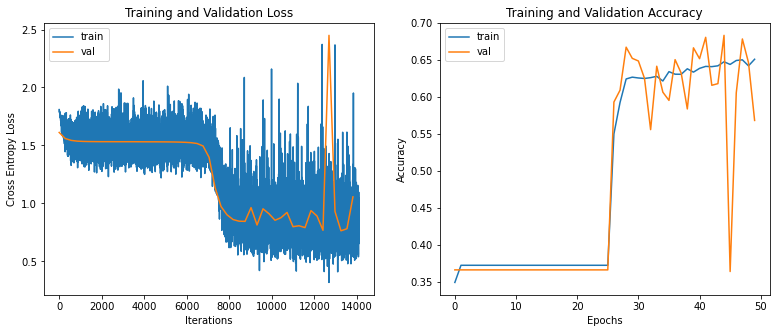

In [43]:
train_loss, train_accuracy, val_loss, val_accuracy = train_nnet(model10, optimizer10, epochs = 50)
plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 50)

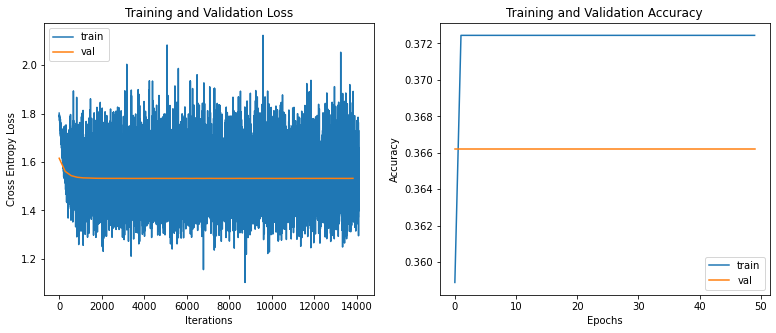

In [44]:
train_loss, train_accuracy, val_loss, val_accuracy = train_nnet(model20, optimizer20, epochs = 50)
plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 50)

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.

The visualization of the performance of model in terms of accuracy and training loss shows a general random training loss for each MLP, we tested. However, a remarkable observation was noted as the depth of the model increases, the model stopped learning -- since the model accuracy was stucked both for the training and validation sets. This invariably shows us that deeper model layer do not necessarily translate to better performance. Also, the deeper layer models takes more time to train and hence, consume more computational resources -- (the not so green part of deep learning).

According to the theory of statistical learning, we expect more complex models to overfit the training data and not generalize well -- (comparing with the performance on the validation data).While, the <a href = "https://openai.com/blog/deep-double-descent/"> Double Descent phenomena </a> is proposing the possibility of seeing model improvement after an initial worse performance, it is always taken as best practice to observe if a model is learning or not for the first few epochs and then re-parameterize it.

#### Change the number of units in hidden layers: (1, 5, 25, 50, 100, 200, ...)


In [45]:
hidden_units=[512, 256, 128, 64, 32]
hidden_units[0]
device

device(type='cuda', index=0)

In [46]:
# your code comes here
class LayeredMLP01(nn.Module):
  def __init__(self, in_size, out_size, hidden_units=[512, 256, 128, 64, 32], device=torch.device("cpu")):
    super(LayeredMLP01, self).__init__()
    # define a network of 5 linear layers
    #h = [h for h in hidden_units.cpu().detach()]
    self.func_in = nn.Linear(in_size, hidden_units[0], device=device)

    function_modules = []

    for i in range(len(hidden_units) - 1):
        function_modules.append(nn.Linear(hidden_units[i], hidden_units[i+1], device=device))
        function_modules.append(nn.ReLU())

    self.func = nn.Sequential(*function_modules)
    self.func_out = nn.Linear(hidden_units[-1], out_size, device= device)

  # define the forward pass of the model
  def forward(self, x):
      x = self.func_in(x)
     # x = nn.ReLU(x)
      x = self.func(x)
      logits = self.func_out(x)
      return logits

# your code comes here
class LayeredMLP02(nn.Module):
  def __init__(self, in_size, out_size, hidden_units=[32, 64, 128, 256, 512], device=torch.device("cpu")):
    super(LayeredMLP02, self).__init__()
    # define a network of 5 linear layers
    #h = [h for h in hidden_units.cpu().detach()]
    self.func_in = nn.Linear(in_size, hidden_units[0], device=device)

    function_modules = []

    for i in range(len(hidden_units) - 1):
        function_modules.append(nn.Linear(hidden_units[i], hidden_units[i+1], device=device))
        function_modules.append(nn.ReLU())

    self.func = nn.Sequential(*function_modules)
    self.func_out = nn.Linear(hidden_units[-1], out_size, device= device)

  # define the forward pass of the model
  def forward(self, x):
      x = self.func_in(x)
     # x = nn.ReLU(x)
      x = self.func(x)
      logits = self.func_out(x)
      return logits

In [47]:
# define model and optimizer
model01 = LayeredMLP01(patch_size*patch_size, K, device=device)
optimizer01 = optim.SGD(model01.parameters(), lr=.01)
print(model01)

LayeredMLP01(
  (func_in): Linear(in_features=784, out_features=512, bias=True)
  (func): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
  )
  (func_out): Linear(in_features=32, out_features=6, bias=True)
)


In [48]:
# define model and optimizer
model02 = LayeredMLP02(patch_size*patch_size, K, device=device)
optimizer02 = optim.SGD(model02.parameters(), lr=.01)
print(model02)

LayeredMLP02(
  (func_in): Linear(in_features=784, out_features=32, bias=True)
  (func): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
  )
  (func_out): Linear(in_features=512, out_features=6, bias=True)
)


In [49]:
model03 = LayeredMLP(patch_size*patch_size, 50, K, device=device)
optimizer03 = optim.SGD(model03.parameters(), lr=.01)
print(model03)

LayeredMLP(
  (nnet): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=6, bias=True)
  )
)


In [50]:
model04 = LayeredMLP(patch_size*patch_size, 25, K, device=device)
optimizer04 = optim.SGD(model04.parameters(), lr=.01)
print(model04)

LayeredMLP(
  (nnet): Sequential(
    (0): Linear(in_features=784, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=25, bias=True)
    (7): ReLU()
    (8): Linear(in_features=25, out_features=6, bias=True)
  )
)


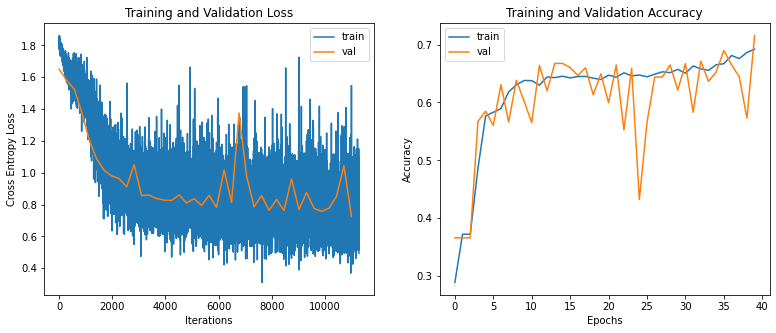

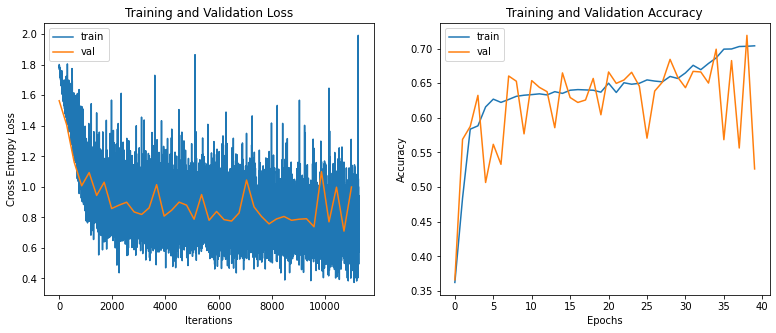

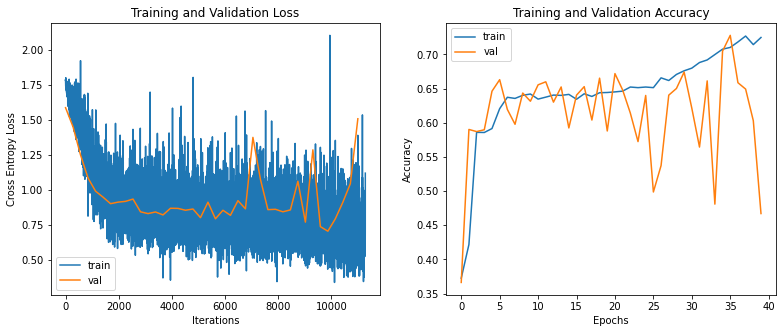

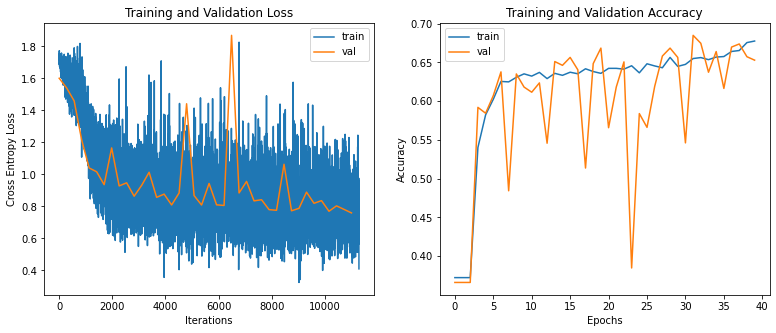

In [51]:
models = [model01, model02, model03, model04]
optimizers = [optimizer01, optimizer02, optimizer03, optimizer04]

for model, optimizer in zip(models, optimizers):
    train_loss, train_accuracy, val_loss, val_accuracy = train_nnet(model, optimizer, epochs = 40)
    plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 40)

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.

Early, we had considered the impact of the model depth on its performance, here, we consider the impact of the model width (which is the number of neurons per layer in model). We see three different cases,
- increasing model width per layer, 
- decreasing model width per layer,
- a constant low model width (50 and 25) per layer

We observe different cases of model overfitting and underfitting. 

#### Test different activation functions such as sigmoid, tanh, Leaky ReLU, etc.

In [52]:
# your code comes here
# define models with different activation functions

# LeakyReLU activation function
class LeakyReLUMLP(nn.Module):
  """[Leaky ReLU Activated model architecture]

  Args:
      nn ([Module]): [Neural Network Model]
      in_size([int])
      out_size([int])
      hidden_units([int])
  """
  def __init__(self, in_size, out_size, hidden_units, device=torch.device("cpu")):
    super(LeakyReLUMLP, self).__init__()
    # define a network of 5 linear layers.
    self.nnet = nn.Sequential(
        nn.Linear(in_size, hidden_units, device=device),
        nn.LeakyReLU(negative_slope=0.03), 
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.LeakyReLU(negative_slope=0.02),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.LeakyReLU(negative_slope=0.02),
        nn.Linear(hidden_units, out_size, device=device),
        nn.LeakyReLU(negative_slope=0.03)
     )
     # define the forward pass of the model

    # We have also to define what is the forward of this module:
  def forward(self, x):
    logits = self.nnet(x)
    return logits


# Sigmoid Activation function
class SigmoidMLP(nn.Module):
  """[Sigmoid Function Activated model architecture]

   Args:
      nn ([Module]): [Neural Network Model]
      in_size([int])
      out_size([int])
      hidden_units([int])
  """
  def __init__(self, in_size, hidden_units, out_size, device=torch.device("cpu")):
    super(SigmoidMLP, self).__init__()
    # define a network of 5 linear layers.
    self.nnet = nn.Sequential(
        nn.Linear(in_size, hidden_units, device=device),
        nn.Sigmoid(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.Sigmoid(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.Sigmoid(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.Sigmoid(),
        nn.Linear(hidden_units, out_size, device=device), 
        nn.Sigmoid()
     )
     # define the forward pass of the model

  # We have also to define what is the forward of this module:
  def forward(self, x):
    logits = self.nnet(x)
    return logits


# TanH Activation function
class TanHMLP(nn.Module):
  """[TanH Function Activated model architecture]]

  Args:
      nn ([Module]): [Neural Network Model]
      in_size([int])
      out_size([int])
      hidden_units([int])
  """
  def __init__(self, in_size, hidden_units, out_size, device=torch.device("cpu")):
    super(TanHMLP, self).__init__()
    # define a network of 5 linear layers.
    self.nnet = nn.Sequential(
        nn.Linear(in_size, hidden_units, device=device),
        nn.Tanh(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.Tanh(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.Tanh(),
        nn.Linear(hidden_units, hidden_units, device=device),
        nn.Tanh(),
        nn.Linear(hidden_units, out_size, device=device), 
        nn.Tanh(),
     )
     # define the forward pass of the model

  # We have also to define what is the forward of this module:
  def forward(self, x):
    logits = self.nnet(x)
    return logits

In [53]:
# define model and optimizer
modelLeaky = LeakyReLUMLP(patch_size*patch_size, K, 256, device=device)
optimizerLeaky = optim.SGD(modelLeaky.parameters(), lr=.01)
print(modelLeaky)

LeakyReLUMLP(
  (nnet): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.03)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.02)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.02)
    (8): Linear(in_features=256, out_features=6, bias=True)
    (9): LeakyReLU(negative_slope=0.03)
  )
)


In [54]:
# define model and optimizer
modelSigmoid = SigmoidMLP(patch_size*patch_size, 256, K, device=device)
optimizerSigmoid = optim.SGD(modelSigmoid.parameters(), lr=.01)
print(modelSigmoid)

SigmoidMLP(
  (nnet): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=256, out_features=6, bias=True)
    (9): Sigmoid()
  )
)


In [55]:
# define model and optimizer
modelTanH = TanHMLP(patch_size*patch_size, 256, K, device=device)
optimizerTanH = optim.SGD(modelTanH.parameters(), lr=.01)
print(modelSigmoid)

SigmoidMLP(
  (nnet): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=256, out_features=6, bias=True)
    (9): Sigmoid()
  )
)


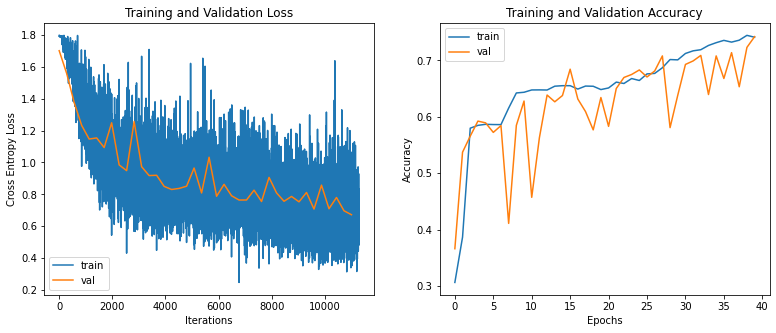

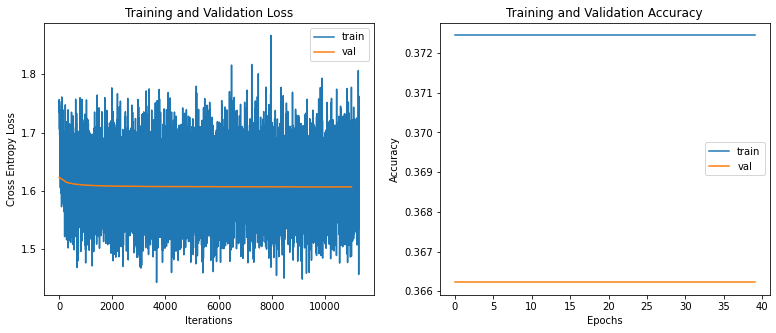

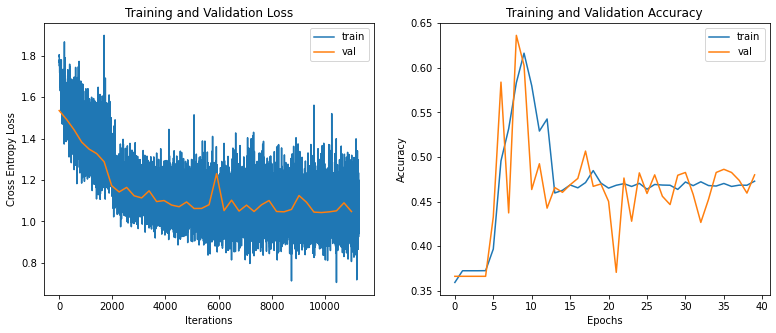

In [56]:
models = [modelLeaky, modelSigmoid, modelTanH]
optimizers = [optimizerLeaky, optimizerSigmoid, optimizerTanH]

for model, optimizer in zip(models, optimizers):
    train_loss, train_accuracy, val_loss, val_accuracy = train_nnet(model, optimizer, epochs = 40)
    plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 40)

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.

- Leaky ReLU
- Sigmoid
- TanH


## Exercise 2: Impact of the optimizer

Retrain the model by using different hyperparameters for the optimizer. You can change it when initializing it, after the initialisation of the model.
* Use different batch sizes (16, 32, 64, 128, 256, 512, and 1024).
* Try different values of the learning rate (between 0.0001 to 10 using a logarithmic scale), and see how it impacts the training proces. Try it on different network architecture. Does they react the same way to different learning rates?
* Increase the number of epochs.
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) or [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html).

#### Try different batch sizes

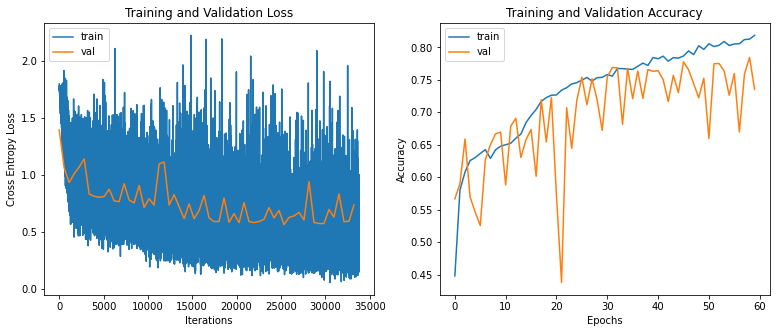

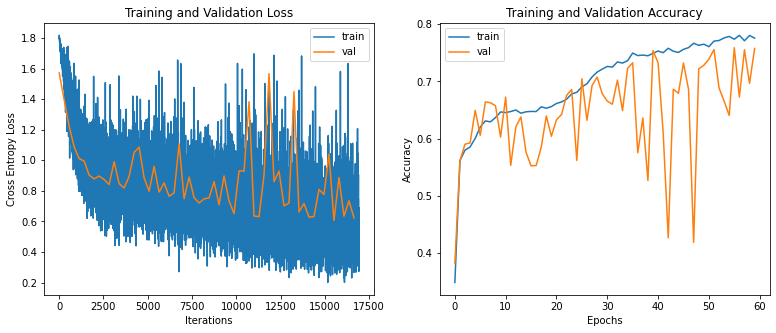

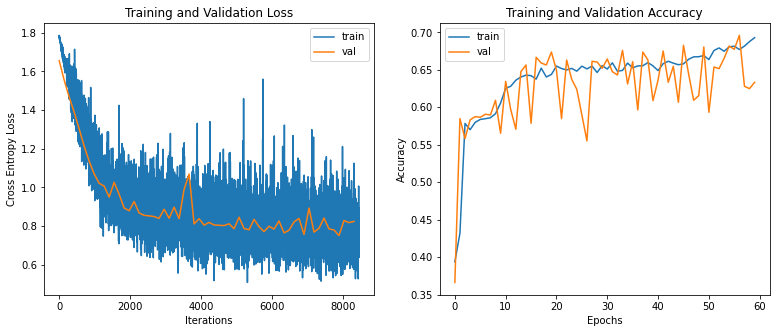

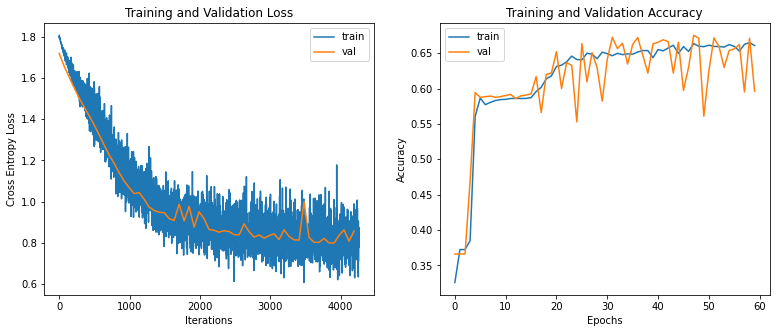

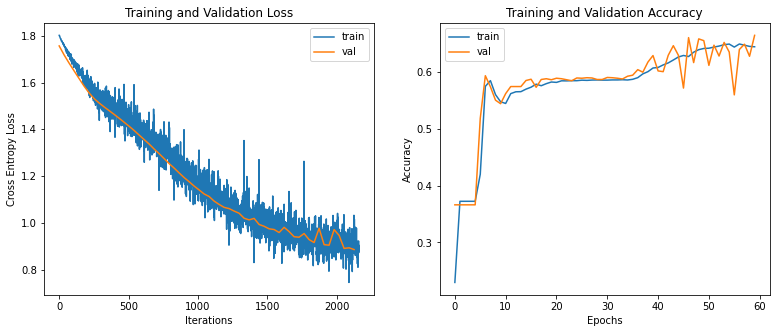

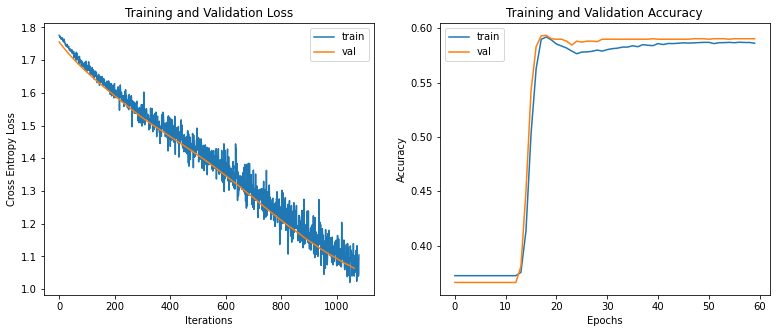

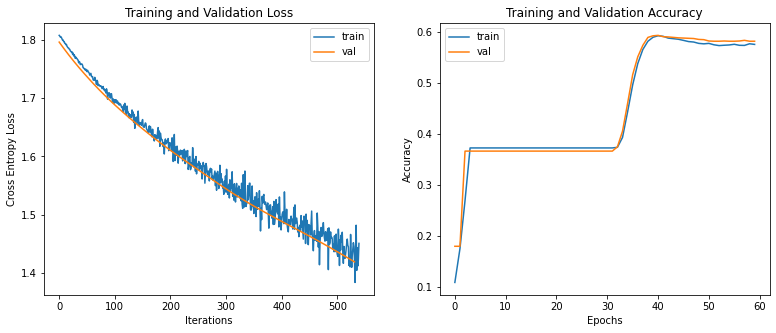

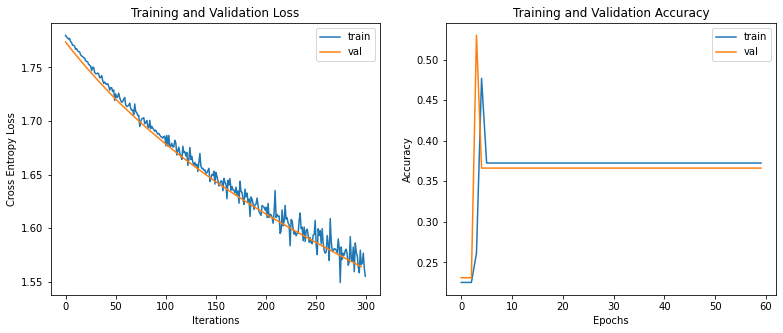

In [57]:
batch_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048] # define batch sizes

for b in batch_sizes:
    train_dataset = TensorDataset(X_train_t, Y_train_t)
    train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=b, shuffle=True)
    # define model and optimizer
    model = LayeredMLP(patch_size*patch_size, 256, K, device=device)
    optimizer = optim.SGD(model.parameters(), lr=.01)
    train_loss, train_accuracy, val_loss, val_accuracy = train_nnet(model, optimizer, epochs = 60)
    plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 60)

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.

#### Different learning rates

In [58]:
lr = [i for i in range(-4, 2)]
lr

[-4, -3, -2, -1, 0, 1]

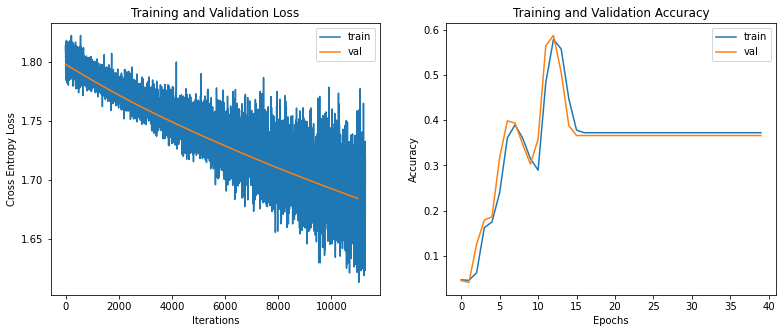

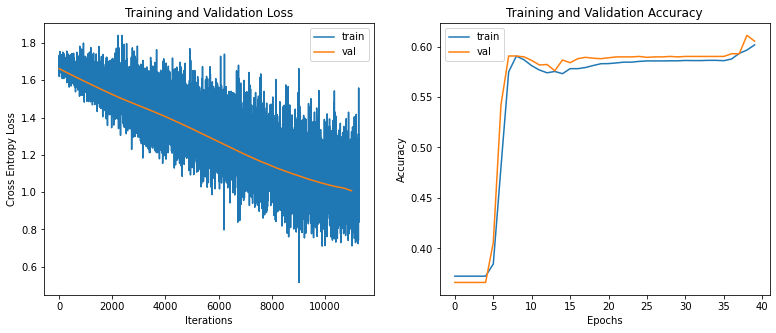

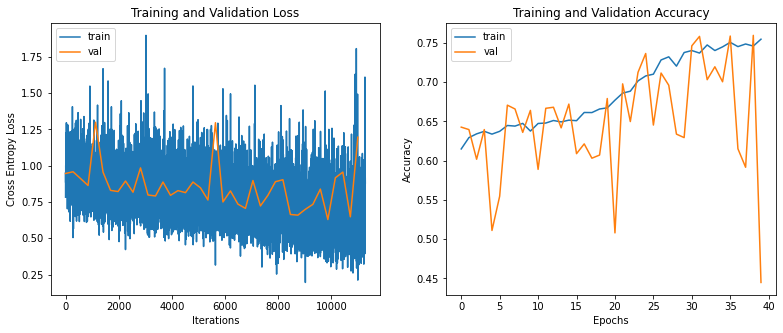

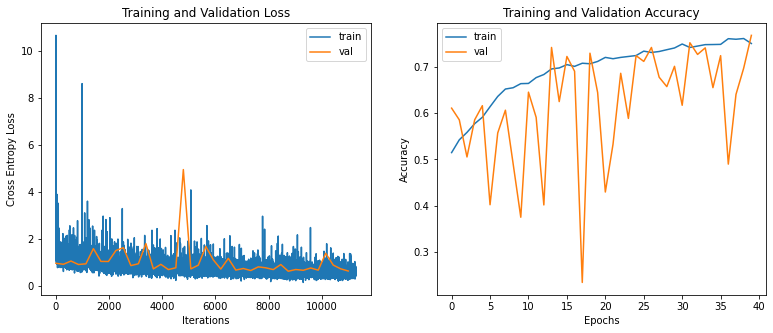

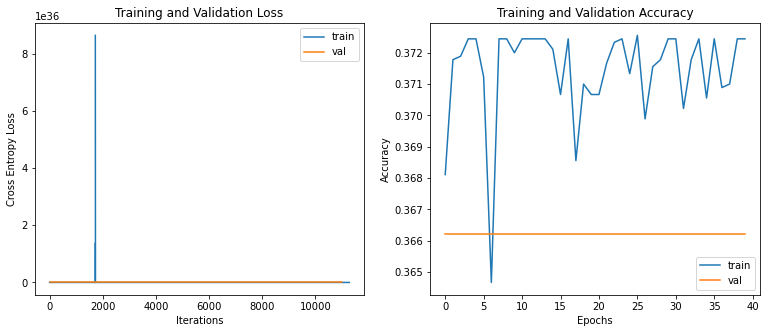

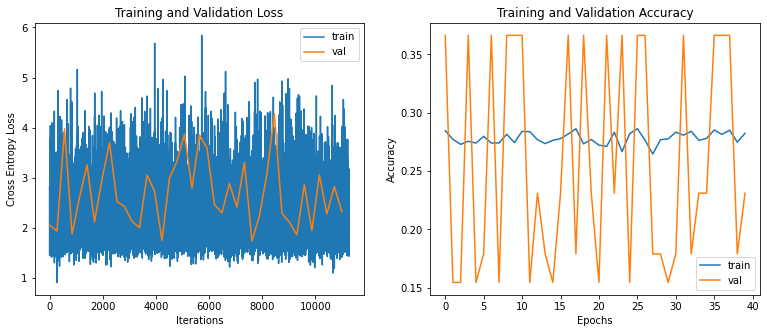

In [59]:
learning_rates = [10**i for i in range(-4, 2)] # using a logarithmic scale

train_dataset = TensorDataset(X_train_t, Y_train_t)
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
# define model and optimizer
model = LayeredMLP(patch_size*patch_size, 256, K, device=device)

for lr in learning_rates:
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_loss, train_accuracy, val_loss, val_accuracy = train_nnet(model, optimizer, epochs = 40)
    plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 40)

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.

#### Different epoch sizes

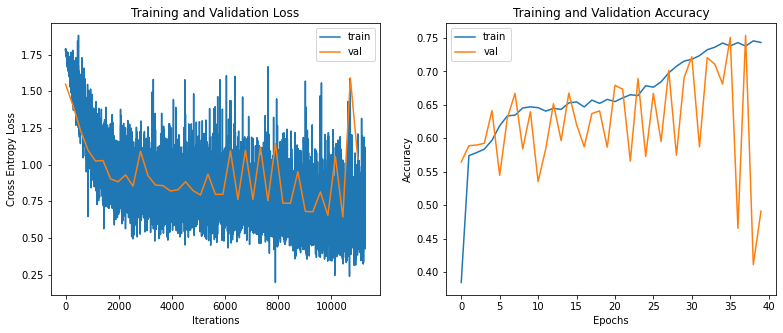

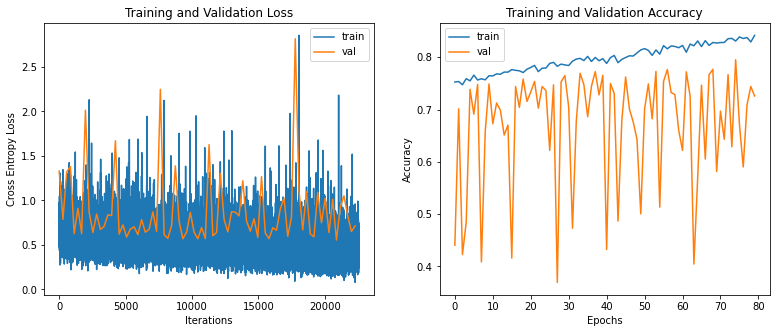

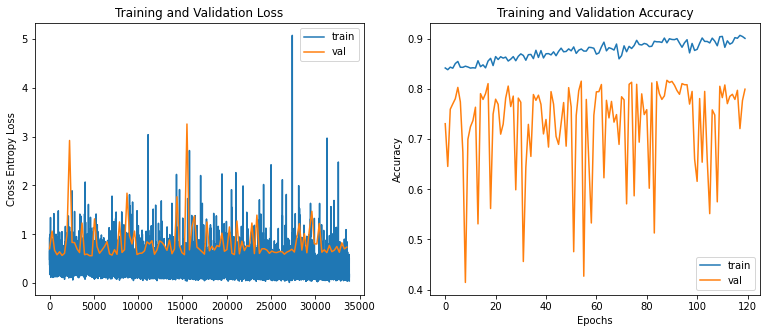

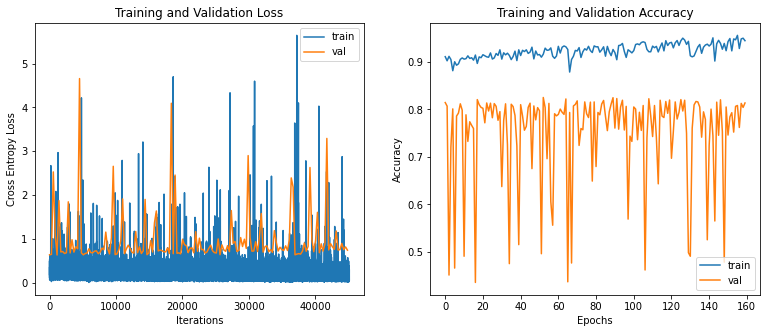

In [60]:
# define model and optimizer
model = LayeredMLP(patch_size*patch_size, 256, K, device=device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

epoch_sizes = np.arange(40, 161, 40) # define different epoch size
for e in epoch_sizes:
    train_loss, train_accuracy, val_loss, val_accuracy = train_nnet(model, optimizer, epochs = e)
    plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = e)

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.

#### Different optimizers 
- Adam, 
- RMSprop
- Adagrad

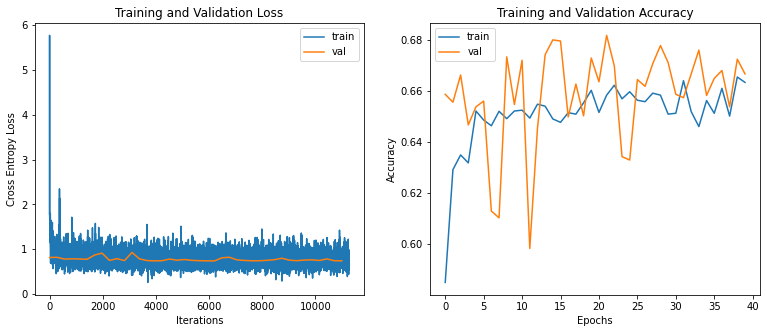

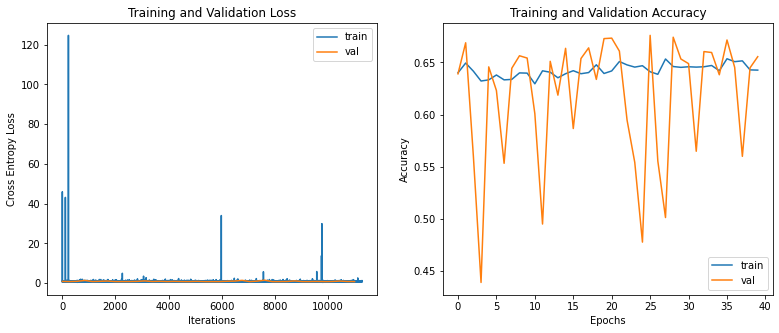

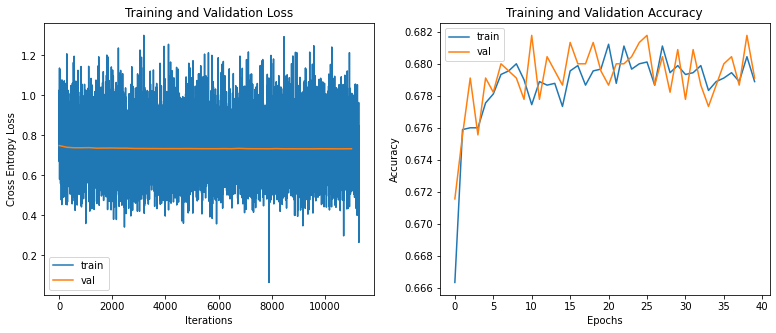

In [61]:
train_dataset = TensorDataset(X_train_t, Y_train_t)
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# define model and optimizer
model = LayeredMLP(patch_size*patch_size, 256, K, device=device)

# define optimizers
optimizer01 = optim.Adam(model.parameters(), lr=0.01)
optimizer02 = optim.RMSprop(model.parameters(), lr=0.01)
optimizer03 = optim.Adagrad(model.parameters(), lr=0.01)

optimizers = [optimizer01, optimizer02, optimizer03]

for optimizer in optimizers:
    train_loss, train_accuracy, val_loss, val_accuracy = train_nnet(model, optimizer, epochs = 40)
    plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 40)

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.

## Exercise 3: Impact of the loss function

* Add a regularization term to the loss function
* Change the cross-entropy loss to the [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) loss. Why this is a poor decision?

#### Add a regularization term to the loss function
- L1 Regularization (Using the L1 Norm), 
- L2 Regularization (Using the Frobenius Norm)

L1 Regularization 

In [62]:
def L1_regularized_nnet(model, optimizer, epochs, lamda, dataloader = train_dataset_loader):
    
    regularization_loss = 0
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    
    
    
    for param in model.parameters():
        for e in range(epochs):
            train_correct = 0
            for x_train_batch, y_train_batch in train_dataset_loader:
                y_hat = model(x_train_batch)
                regularization_loss += torch.sum(abs(param))
                classif_loss = loss_func(y_hat, y_train_batch)
                loss = classif_loss + 0.001 * regularization_loss
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                y_hat_class = torch.argmax(y_hat.detach(), axis=1) # we assign an appropriate label based on the network's prediction
                train_correct += torch.sum(y_hat_class==y_train_batch)
                train_loss.append(loss.item())

            train_accuracy.append(train_correct/len(train_dataset_loader.dataset))
            y_val_hat = model(X_val_t) # forward pass
            val_loss.append(loss_func(y_val_hat, Y_val_t).item()) # compute the loss
            y_val_hat_class = torch.argmax(y_val_hat, axis=1) # we assign an appropriate label based on the network's prediction
            val_acc = torch.sum(y_val_hat_class==Y_val_t)/len(Y_val_t)
            val_accuracy.append(val_acc)
            
    return train_loss, train_accuracy, val_loss, val_accuracy


In [63]:
reg_param = [0.001, 0.01, 0.05, 0.1, 0.2]

for lamda in reg_param:
    model = LayeredMLP(patch_size*patch_size, 256, K, device=device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    L1_regularized_nnet(model, optimizer, 40,lamda, dataloader = train_dataset_loader)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
model = LayeredMLP(patch_size*patch_size, 256, K, device=device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
L1_regularized_nnet(model, optimizer, 40, 0.01, dataloader = train_dataset_loader)

In [ ]:
reg_param = [0.001, 0.01, 0.05, 0.1, 0.2]
reg_param

[0.001, 0.01, 0.05, 0.1, 0.2]

L2 Regularization 

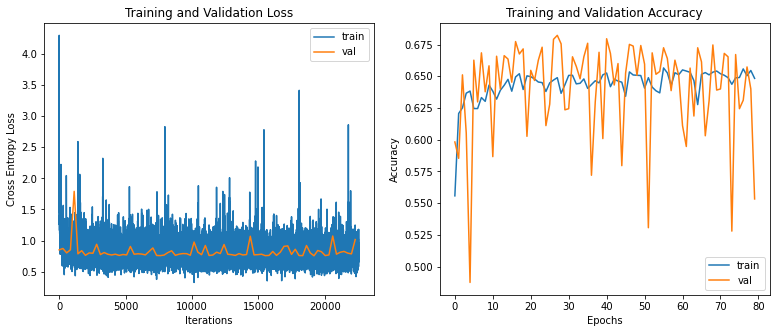

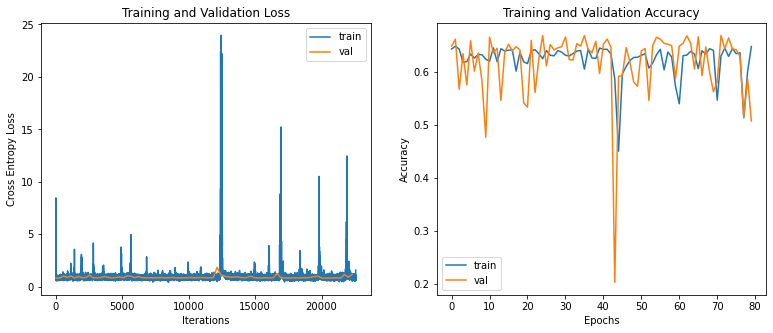

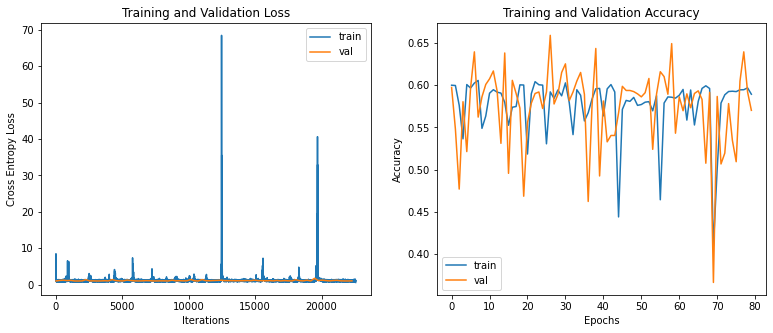

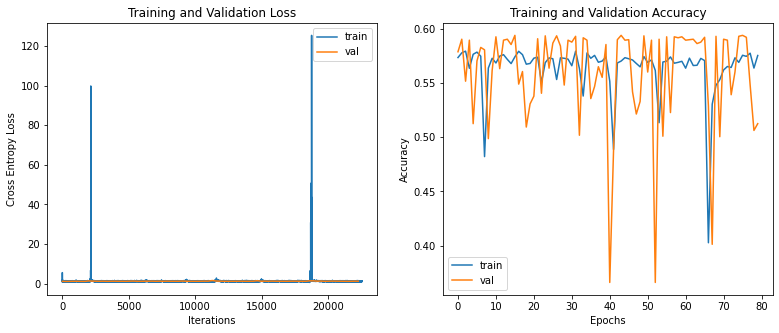

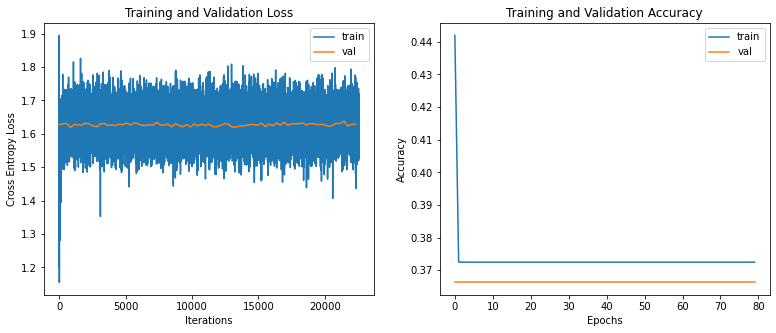

In [ ]:
reg_param = [0.001, 0.01, 0.05, 0.1, 0.2]
model = LayeredMLP(patch_size*patch_size, 256, K, device=device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

for r in reg_param:
    # define model and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=r)
    train_loss, train_accuracy, val_loss, val_accuracy = train_nnet(model, optimizer, epochs = 80)
    plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 80)

#### Change the Cross Entropy Loss to the MSE Loss

In [ ]:
def mseLossFunc(y_hat, y):
    nn.MSELoss()(y_hat.type(torch.float), y.type(torch.float))

In [ ]:
# define functions for training model and display model performance
def train_nnetMSE(model, optimizer, epochs, dataloader=train_dataset_loader):
    # training the nnet
    train_loss = [] # where we keep track of the training loss
    train_accuracy = [] # where we keep track of the training accuracy of the model
    val_loss = [] # where we keep track of the validation loss
    val_accuracy = [] # where we keep track of the validation accuracy of the model
    mse_loss = nn.MSELoss()
    for e in range(epochs):
        train_correct = 0
        for x_train_batch, y_train_batch in train_dataset_loader:
            y_hat = model(x_train_batch) # forward pass
            
            #y_hat_class = torch.argmax(y_hat.detach(), axis=1) 
            loss = mseLossFunc(y_hat, y_train_batch) # compute the loss
            loss.backward() # obtain the gradients with respect to the loss
            optimizer.step() # perform one step of gradient descent
            optimizer.zero_grad() # reset the gradients to 0
            y_hat_class = torch.argmax(y_hat.detach(), axis=1) # we assign an appropriate label based on the network's prediction
            train_correct += torch.sum(y_hat_class==y_train_batch)
            train_loss.append(loss.item())
            
        train_accuracy.append(train_correct/len(train_dataset_loader.dataset)) 
        y_val_hat = model(X_val_t) # forward pass
        val_loss.append(loss_func(y_val_hat, Y_val_t).item()) # compute the loss
        y_val_hat_class = torch.argmax(y_val_hat, axis=1) # we assign an appropriate label based on the network's prediction
        val_acc = torch.sum(y_val_hat_class==Y_val_t)/len(Y_val_t)
        val_accuracy.append(val_acc)

    return train_loss, train_accuracy, val_loss, val_accuracy


In [ ]:
model = LayeredMLP(patch_size*patch_size, 256, K, device=device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=r)

# train_loss, train_accuracy, val_loss, val_accuracy = train_nnetMSE(model, optimizer, epochs = 40)
# plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 40)

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.


Why is using the MSE Loss in this context, a poor decision?
Conceptually, the MSE Loss is not used for classification problem (both binary and multiclass classification problems). For classification, it outputs a false sense of error since it penalises the difference between class number, emphasizing differences between classes as large error. 

Although the MSE Loss is popular for evaluating the performance of regression models, it can also be used for evaluating classification, that are underlying regression tasks. In such cases, it is called the Brier score. However, in cases like this where we have to predict the class of an input rather than it's probability or threshold, it can become problematic since it is not guaranteed to minimize the cost function and it also assumes a Gaussian distribution for the classes. Geometrically, measuring the MSE loss around the target value by the Gaussian noise is justifiable.

## Exercise 4: Prediction on test

Once you have a model that seems satisfying on the validation set, you should evaluate it on a test dataset that has never been used before in order to obtain a final accuracy value.

In [83]:
# save best model
# reload the best model
# predict based on the saved model
train_dataset = TensorDataset(X_train_t, Y_train_t)
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

##### Load optimal model
- Retrain the best model architecture found, 
- Save model, 
- Test model performance on test sets

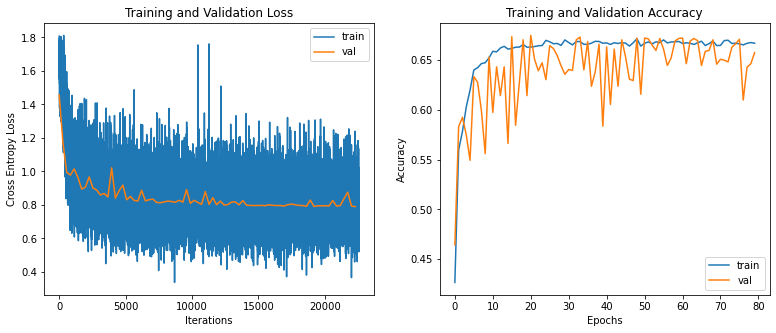

In [91]:
optimalModel = LayeredMLP(patch_size*patch_size, 256, K, device=device)
optimizer = optim.Adagrad(optimalModel.parameters(), lr=0.001, weight_decay=0.01)
train_loss, train_accuracy, val_loss, val_accuracy = train_nnet(optimalModel, optimizer, epochs = 80)
plot_performance(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 80)

In [92]:
torch.save(optimalModel.state_dict(), "data/model/bestmodel_checkpoint.pth")

In [93]:
checkpoint = torch.load("data/model/bestmodel_checkpoint.pth")

In [94]:
best_model = LayeredMLP(patch_size*patch_size, 256, K, device=device)
best_model.load_state_dict(
    torch.load("data/model/bestmodel_checkpoint.pth")
)
best_model.eval()

# predict
predictions = best_model(X_test_t)
predicted_class = torch.argmax(predictions.detach(), axis = 1)

In [95]:
test_accuracy = torch.sum(predicted_class==Y_test_t)/len(Y_test_t)
test_accuracy

tensor(0.2272, device='cuda:0')

In [96]:
from sklearn import metrics

print("Classification report for classifier %s:\n%s\n"
      % (best_model, metrics.classification_report(Y_test_t.detach().cpu(), predicted_class.cpu())))

Classification report for classifier LayeredMLP(
  (nnet): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=6, bias=True)
  )
):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       172
           1       0.23      1.00      0.37       852
           2       0.00      0.00      0.00       654
           3       0.00      0.00      0.00       599
           4       0.00      0.00      0.00        98
           5       0.00      0.00      0.00      1375

    accuracy                           0.23      3750
   macro avg       0.04      0.17      0.06      3750
weighted avg       0.05      0.23      0.08      3750




C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
from torchvision.utils import make_grid
def show_images(img):
    #img = (img - img.min())/(img.max()-img.min())
    npimg = img.numpy()
    plt.figure(figsize=(8*4,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

This model does not generalize well to the test sets. Implying that while it performed well on the validation sets that informed the selection of the hyperparameters, the ultimate source of the evaluating the model performance is using the test sets. In cases like this, the first point of call is to tweak the model architectures and other architectures in the model to better improve the model performance. 